# Cryptocurrencies prediction

Ce projet a pour but de prédire la valeur des differentes cryptomonnaies existantes et ainsi d'élaborer une stratégie pour déterminer sur quelle(s) cryptomonnaie(s) investir.

Pour ce projet, nous avons utilisé l'api coingecko, qui est une api gratuite et qui permet d'obtenir divers informations sur les cryptomonmaies.

API coingecko : https://www.coingecko.com/api/documentations/v3

## Importation des librairies nécessaires

In [43]:
import numpy as np
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import time
import datetime
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller #Augmented Dickey-Fuller test
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plot

## Acquisition des données

Pour l'acquisition des données, nous avons utilisé la requête suivante : https://api.coingecko.com/api/v3/coins/{cryptocurrency}/market_chart/range?vs_currency={devise}usd&from={date_debut}&to={date_fin}

* cryptocurrency : la cryptomonnaie que l'on souhaite avoir des informations
* devise: valeur de la cryptomonnaie pour cette devise, ex: usd (pour dollars)
* date_debut : date de début (en timestamp) de l'acquisition des données
* date_fin : date de fin (en timestamp) de l'acquisition des données

In [2]:
start_date = "20/11/2020"
end_date = "25/11/2020"
start_timestamp = int(time.mktime(datetime.datetime.strptime(start_date, "%d/%m/%Y").timetuple()))
end_timestamp  = int(time.mktime(datetime.datetime.strptime(end_date, "%d/%m/%Y").timetuple()))

print(start_timestamp, end_timestamp)

1605826800 1606258800


In [3]:
currency="bitcoin"
url = 'https://api.coingecko.com/api/v3/coins/'+currency+'/market_chart/range?'
parameters = {
    'vs_currency':'usd',
    'from':start_timestamp,
    'to':end_timestamp
}

session = Session()

try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    mypath = os.path.abspath('')
    path_to_save = str(mypath) + '/../data/'
    df = pd.DataFrame(data["prices"])
    file_name = "data.csv"
    df.to_csv(os.path.join(path_to_save, file_name))
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

In [4]:
csv_file_name = '../data/data.csv' #please put the name of the csv file you want to read
data = pd.read_csv(csv_file_name, index_col=[0],sep=',', encoding="utf-8")
data.iloc[:5] # we display the first 5 rows

,0,1
0,1605827332571,17878.504943
1,1605831039446,17822.996753
2,1605834375784,17775.271933
3,1605838402527,17940.763174
4,1605842903104,17987.234295


In [5]:
data.columns = ['time', 'price']

In [6]:
data['time'] = data['time'].astype(str).str[:-3].astype(np.int64)

In [7]:
data

,time,price
0,1605827332,17878.504943
1,1605831039,17822.996753
2,1605834375,17775.271933
3,1605838402,17940.763174
4,1605842903,17987.234295
...,...,...
115,1606241189,19135.703235
116,1606245256,19192.871932
117,1606249215,19139.487099
118,1606252332,19017.571635


In [8]:
data['time'] = pd.to_datetime(data['time'], unit='s')

In [9]:
data

,time,price
0,2020-11-19 23:08:52,17878.504943
1,2020-11-20 00:10:39,17822.996753
2,2020-11-20 01:06:15,17775.271933
3,2020-11-20 02:13:22,17940.763174
4,2020-11-20 03:28:23,17987.234295
...,...,...
115,2020-11-24 18:06:29,19135.703235
116,2020-11-24 19:14:16,19192.871932
117,2020-11-24 20:20:15,19139.487099
118,2020-11-24 21:12:12,19017.571635


In [10]:
data = data.set_index('time')

## Affichage de la donnée

In [11]:
def plotting(serie, title):
    plot.figure(figsize=(15,5))
    plot.plot(serie)
    plot.xlabel('Date', fontsize=12)
    plot.ylabel('Price in USD', fontsize=12)
    plot.title(title, fontsize=15)
    plot.show()

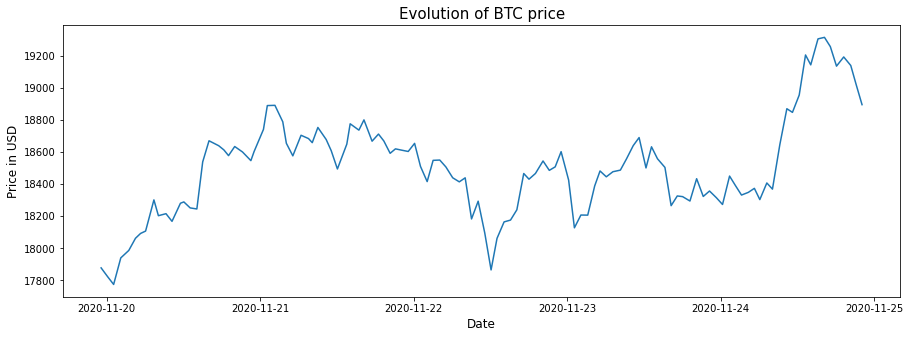

In [12]:
plotting(data, "Evolution of BTC price")

## Test de la stationnarité

Pour avoir un bon modèle de prédiction, il faut que les observations soient stationnaires (càd que la moyenne et la variance sont constantes le long des observations).

Une des méthodes est d'utilisé le test augmenté de dickey fuller (adf). Pour que les observations soient stationnaires, il faut que le résultat p du test adf soit inférieur à 0.05.

In [13]:
def ADFtest(serie):
    val = serie.values
    result = adfuller(val)
    print('ADF Statistic: ' + str(result[0])) # the more negative, the more we reject null hypothesis = stationnary
    print('p-value: ' + str(result[1])) # p<0.05 => reject null hypothesis = stationnary

In [14]:
ADFtest(data)

ADF Statistic: -2.3372632719105195
p-value: 0.16023123919483928


On voit que la valeu de p est supérieur à 0.05 donc notre serie n'est pas stationnaire.
Nous allons apppliqué un log à notre serie pour enlever les trop grandes valeur qui pouraient biaiser notre serie.

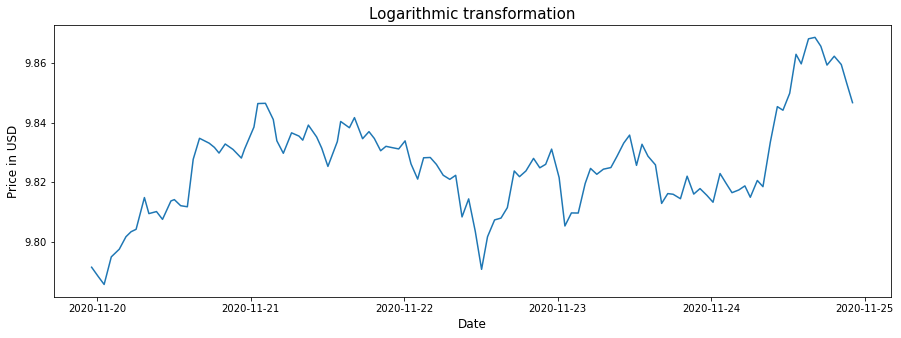

ADF Statistic: -2.363417679071498
p-value: 0.15232874611120006


In [15]:
logTransformed = np.log(data)
plotting(logTransformed,"Logarithmic transformation")
ADFtest(logTransformed)
    

On observe une valeur de p inférieur à celle trouvée précédement mais toujours supérieur à 0.05, donc nous n'avons toujours pas quelque chose de stationnaire.

Nous allons appliquer une autre transformation qui est la difference. Nous allons soustraire l'observation courante avec les observations précédentes. Cette difference permet de supprimer les tendances et les saisons tout en gardant la même moyenne.

# ⚠️ Voir autre methode pour rendre une serie stationnaire.

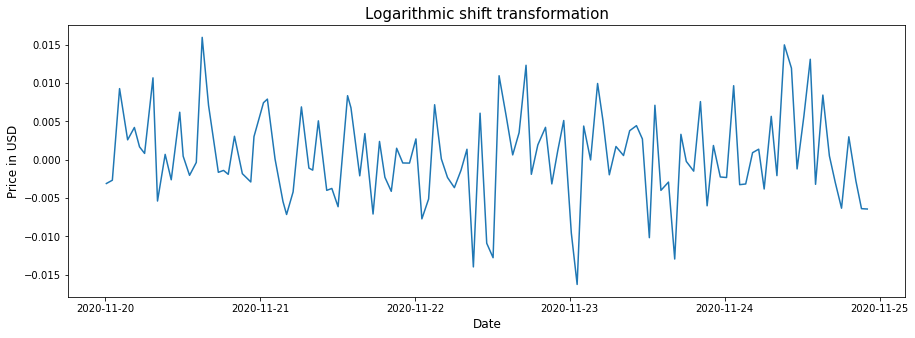

ADF Statistic: -10.726209263388963
p-value: 3.060827635053198e-19


In [16]:
logDiffTransformed = logTransformed - logTransformed.shift()
logDiffTransformed = logDiffTransformed.iloc[1:]
plotting(logDiffTransformed,"Logarithmic shift transformation")

ADFtest(logDiffTransformed)

On voit que nous avons une valeur de p inférieur à 0.05, donc nous avons quelque chose de stationnaire. 

On peut appuyer notre test de stationnarité avec la fonction d'autocorrélation.

## Fonction d'auto corrélation

In [17]:
def autocorrelation(serie):
    val = serie.values
    fig = tsaplots.plot_acf(val, lags=10)
    

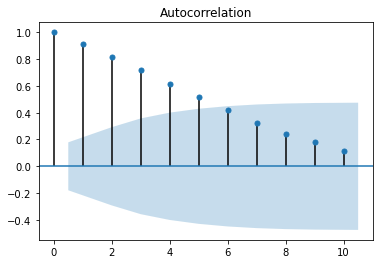

In [18]:
autocorrelation(data)

Nous avons quelque chose de très corrélé. Mais pas stationnaire, il faut que tous les pics soient dans la zone blue.

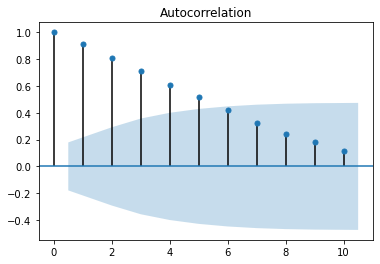

In [19]:
autocorrelation(logTransformed)

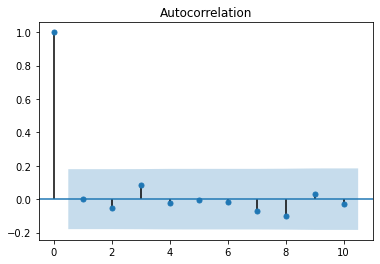

In [20]:
autocorrelation(logDiffTransformed)

Lorsque nous faissons le log et la difference de nos données, nous avons bienn quelque chose de stationnaire, car tous les pics sont dans la zone bleu (rappel: le pic à 0 ne compte pas).

## Modèle auto régressif (AR)

Le modèle auto régressif utilise les précédentes observations pour prédire pour prédire l'observations suivantes.
Pour determiner ce modèle, nous devons determiner combien de valeurs passés ne devont prendre en compte.

Pour cela nous allons utilisé la fonction d'autocorrélation partielle. L' autocorrélation partielle, c'est juste la corrélation direct (corréalation indirect pas pirs en compte contrairement à l'autocorrélation). **A peaufiner***

In [21]:
def partial_autocorrelation(serie):
    val = serie.values
    fig = tsaplots.plot_pacf(val)

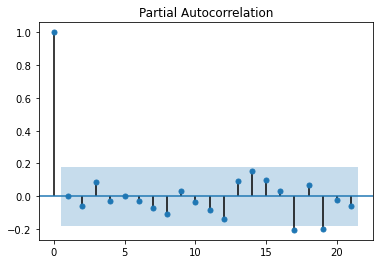

In [22]:
partial_autocorrelation(logDiffTransformed)

Maintenant il faut regarder le nombre de pics important qui sortent de la zone bleu. Il n'y en a aucun pour nous (il y'en a 2 mais ils sont très proche de la zone bleu et ils sont très loin, donc ils doivent être surement dûs à cause d'erreur aléatoire). Prenons donc un modèle AR d'ordre 1.

In [23]:
def AR(serie, p):
    val=serie.values
    model = ARIMA(val, order=(p,0,0))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

In [24]:
AR(logDiffTransformed, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  119
Model:                     ARMA(1, 0)   Log Likelihood                 440.314
Method:                       css-mle   S.D. of innovations              0.006
Date:                Sat, 28 Nov 2020   AIC                           -874.628
Time:                        14:32:48   BIC                           -866.291
Sample:                             0   HQIC                          -871.243
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.848      0.397      -0.001       0.002
ar.L1.y    -2.151e-06      0.092  -2.34e-05      1.000      -0.180       0.180
                                    Roots           

## Modèle moyenne mobile (MA)

Dans un modolèe à moyenne mobile, les observations dépendent des erreurs passées.
Pour determiner ce modèle, nous devons determiner combien de valeurs passés ne devont prendre en compte.

Pour cela nous allons utilisé la fonction d'autocorrélation. L'autocorrélation prend en compte les corrélations directs et indirects.

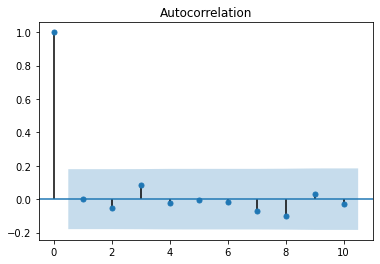

In [25]:
autocorrelation(logDiffTransformed)

Nous sommes normalement sencés prendre pour nombre de valeur pour la modèle à moyenne mobile le nombre de pics important en dehors de la zone blue, sauf que comme il n'y en a aucun, nous allons prendre une seul valeur.

In [26]:
def MA(serie, q):
    val=serie.values
    model = ARIMA(val, order=(0,0,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

In [27]:
MA(logDiffTransformed, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  119
Model:                     ARMA(0, 1)   Log Likelihood                 440.314
Method:                       css-mle   S.D. of innovations              0.006
Date:                Sat, 28 Nov 2020   AIC                           -874.628
Time:                        14:32:53   BIC                           -866.291
Sample:                             0   HQIC                          -871.243
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.848      0.397      -0.001       0.002
ma.L1.y     -2.15e-06      0.098   -2.2e-05      1.000      -0.191       0.191
                                    Roots           

## je ne sais pas trop quoi en dire ⚠️

## Modèle ARMA

Le modèle ARMA est juste une combinaison du modèle AR et du modèle MA. **Expliquer l'interêt***

In [28]:
def ARMA(serie, p,q):
    val=serie.values
    model = ARIMA(val, order=(p,0,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

In [29]:
ARMA(logDiffTransformed, 1, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  119
Model:                     ARMA(1, 1)   Log Likelihood                 441.428
Method:                       css-mle   S.D. of innovations              0.006
Date:                Sat, 28 Nov 2020   AIC                           -874.857
Time:                        14:32:57   BIC                           -863.740
Sample:                             0   HQIC                          -870.343
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.699      0.089   -5.03e-05       0.001
ar.L1.y        0.9407      0.037     25.195      0.000       0.867       1.014
ma.L1.y       -1.0000      0.022    -45.514      0.0

**quoi dire?**

## Modèle ARIMA

Le modèle ARIMA est comme le modèle ARMA sauf que cette fois-ci on ajouté un nouveau paramètre, d. 
d represente le nombre de difference non saisonnère requis pour la stationarité. d permet de rendre des données non stationnaires, sationtionnaires.

**Comment choisir d?**

In [30]:
def myARIMA(serie, p, d, q):
    val=serie.values
    model = ARIMA(val, order=(p,d,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

In [31]:
myARIMA(logDiffTransformed, 1, 1, 1)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  118
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 433.795
Method:                       css-mle   S.D. of innovations              0.006
Date:                Sat, 28 Nov 2020   AIC                           -859.590
Time:                        14:33:00   BIC                           -848.507
Sample:                             1   HQIC                          -855.090
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.776e-06   1.61e-05     -0.358      0.720   -3.74e-05    2.59e-05
ar.L1.D.y      0.0076      0.093      0.082      0.934      -0.174       0.189
ma.L1.D.y     -1.0000      0.028    -35.332      0.0

## Quel modèle choisir ?
Maintenant que nous avons 4 modèles, quel modèle choisir ?
On peut le choisir selon le  Akaike Information Criterion (AIC) ou le Bayesian Information Criterion (BIC).
Dans notre cas, nous allos choisir le AIC. Il faut donc choisir celui qui a le AIC le plus faible.

| modèle  | AIC      |
| ------- |---------:|
| AR      | -874.628 |
| MA      | -874.628 |
| ARMA    | -874.857 |
| ARIMA   | -859.590 |

Le modèle ARMA est donc le meilleur modèle (à noter que le differencing du ARIMA n'a rien apporté)
### Une autre méthode à faire pour trouver le bon modèle est de calculer l'erreur quadratique moyenne de chaque et de prendre celui qui a la plus faible ⚠️ à faire


## Validation du modèle

In [20]:
model = ARIMA(data.values, order=(1,0,1))
model_fit = model.fit(disp=0)

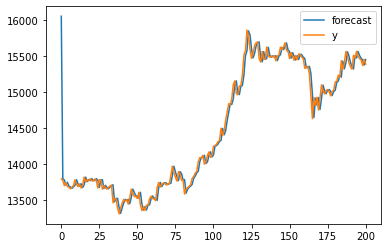

In [21]:
fig = model_fit.plot_predict(start=0, end=200)

# Essai avec plus de données

In [1]:
import numpy as np
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import time
import datetime
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller #Augmented Dickey-Fuller test
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plot

In [38]:
start_date = "01/11/2020"
end_date = "29/11/2020"
start_timestamp = int(time.mktime(datetime.datetime.strptime(start_date, "%d/%m/%Y").timetuple()))
end_timestamp  = int(time.mktime(datetime.datetime.strptime(end_date, "%d/%m/%Y").timetuple()))

print(start_timestamp, end_timestamp)

currency="bitcoin"
url = 'https://api.coingecko.com/api/v3/coins/'+currency+'/market_chart/range?'
parameters = {
    'vs_currency':'usd',
    'from':start_timestamp,
    'to':end_timestamp
}

session = Session()

try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    mypath = os.path.abspath('')
    path_to_save = str(mypath) + '/../data/'
    df = pd.DataFrame(data["prices"])
    file_name = "data.csv"
    df.to_csv(os.path.join(path_to_save, file_name))
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

csv_file_name = '../data/data.csv' #please put the name of the csv file you want to read
data = pd.read_csv(csv_file_name, index_col=[0],sep=',', encoding="utf-8")
data.iloc[len(data)-5:] # we display the first 5 rows

1604185200 1606604400


,0,1
667,1606586971157,17749.984304
668,1606590261194,17698.715487
669,1606594025820,17806.829995
670,1606598516837,17732.254867
671,1606602248981,17716.169742


In [3]:
data.columns = ['time', 'price']

data['time'] = data['time'].astype(str).str[:-3].astype(np.int64)

data['time'] = pd.to_datetime(data['time'], unit='s')

data = data.set_index('time')

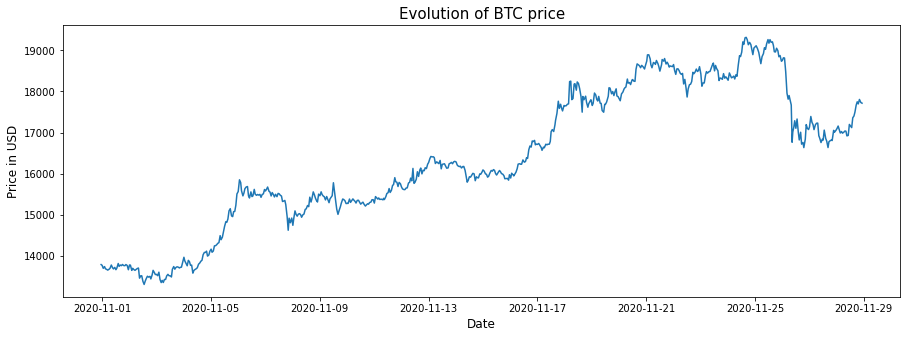

In [4]:
def plotting(serie, title):
    plot.figure(figsize=(15,5))
    plot.plot(serie)
    plot.xlabel('Date', fontsize=12)
    plot.ylabel('Price in USD', fontsize=12)
    plot.title(title, fontsize=15)
    plot.show()

plotting(data, "Evolution of BTC price")

In [6]:
def ADFtest(serie):
    val = serie.values
    result = adfuller(val)
    print('ADF Statistic: ' + str(result[0])) # the more negative, the more we reject null hypothesis = stationnary
    print('p-value: ' + str(result[1])) # p<0.05 => reject null hypothesis = stationnary

ADFtest(data) 

ADF Statistic: -1.398756404379922
p-value: 0.5828721684660381


On voit que la valeu de p est supérieur à 0.05 donc notre serie n'est pas stationnaire.
Nous allons apppliqué un log à notre serie pour enlever les trop grandes valeur qui pouraient biaiser notre serie.

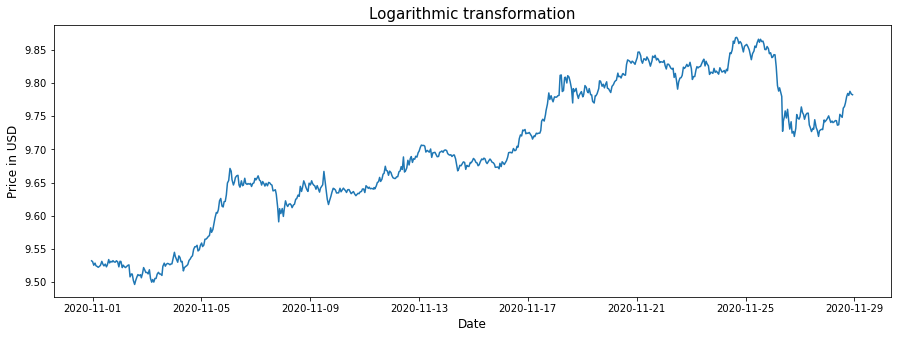

ADF Statistic: -1.464981835891638
p-value: 0.5507577740512177


In [7]:
logTransformed = np.log(data)
plotting(logTransformed,"Logarithmic transformation")
ADFtest(logTransformed)

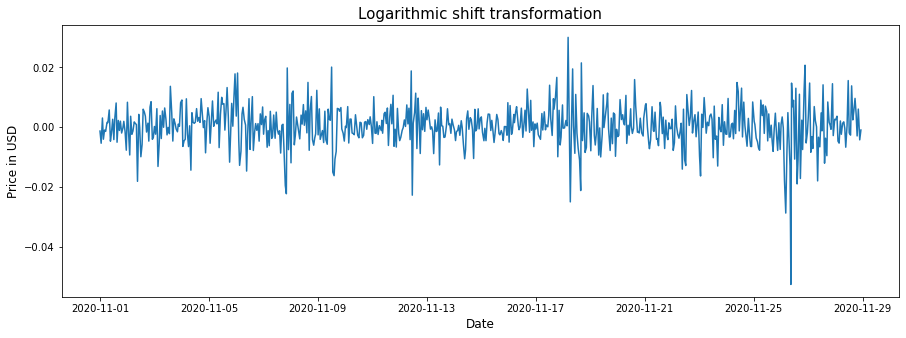

ADF Statistic: -20.092810195032783
p-value: 0.0


In [8]:
logDiffTransformed = logTransformed - logTransformed.shift()
logDiffTransformed = logDiffTransformed.iloc[1:]
plotting(logDiffTransformed,"Logarithmic shift transformation")

ADFtest(logDiffTransformed)

## Fonction d'autocorrélation

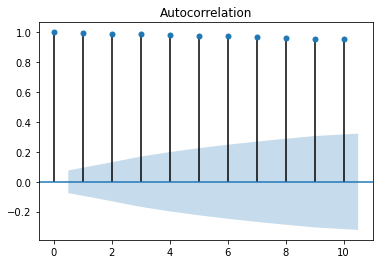

In [9]:
def autocorrelation(serie):
    val = serie.values
    fig = tsaplots.plot_acf(val, lags=10)
    

autocorrelation(data)

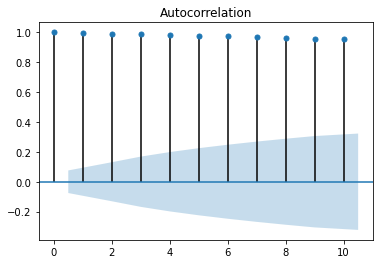

In [10]:
#Nous avons quelque chose de très corrélé. Mais pas stationnaire, il faut que tous les pics soient dans la zone blue.

autocorrelation(logTransformed)

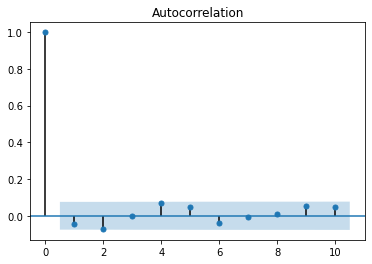

In [11]:
autocorrelation(logDiffTransformed)

## Modèle Auto regressif (AR)

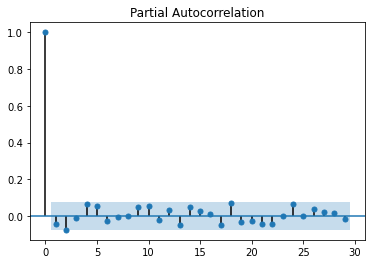

In [12]:
def partial_autocorrelation(serie):
    val = serie.values
    fig = tsaplots.plot_pacf(val)

partial_autocorrelation(logDiffTransformed)

In [13]:
def AR(serie, p):
    val=serie.values
    model = ARIMA(val, order=(p,0,0))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

AR(logDiffTransformed, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  671
Model:                     ARMA(1, 0)   Log Likelihood                2375.124
Method:                       css-mle   S.D. of innovations              0.007
Date:                Sun, 29 Nov 2020   AIC                          -4744.249
Time:                        19:47:55   BIC                          -4730.722
Sample:                             0   HQIC                         -4739.010
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.438      0.151      -0.000       0.001
ar.L1.y       -0.0451      0.039     -1.171      0.241      -0.121       0.030
                                    Roots           

## Modèle Moyenne mobile (MA)

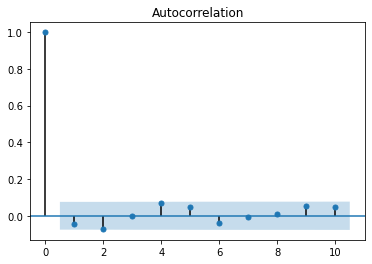

In [14]:
autocorrelation(logDiffTransformed)

Nous sommes normalement sencés prendre pour nombre de valeur pour la modèle à moyenne mobile le nombre de pics important en dehors de la zone blue, sauf que comme il n'y en a aucun, nous allons prendre une seul valeur.



In [16]:
def MA(serie, q):
    val=serie.values
    model = ARIMA(val, order=(0,0,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

MA(logDiffTransformed, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  671
Model:                     ARMA(0, 1)   Log Likelihood                2375.240
Method:                       css-mle   S.D. of innovations              0.007
Date:                Sun, 29 Nov 2020   AIC                          -4744.481
Time:                        19:49:56   BIC                          -4730.954
Sample:                             0   HQIC                         -4739.242
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.453      0.146      -0.000       0.001
ma.L1.y       -0.0528      0.042     -1.269      0.204      -0.134       0.029
                                    Roots           

## Modèle ARMA

In [17]:
def ARMA(serie, p,q):
    val=serie.values
    model = ARIMA(val, order=(p,0,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

ARMA(logDiffTransformed, 1, 1)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  671
Model:                     ARMA(1, 1)   Log Likelihood                2375.856
Method:                       css-mle   S.D. of innovations              0.007
Date:                Sun, 29 Nov 2020   AIC                          -4743.711
Time:                        19:51:46   BIC                          -4725.676
Sample:                             0   HQIC                         -4736.726
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.523      0.128      -0.000       0.001
ar.L1.y        0.3561      0.271      1.314      0.189      -0.175       0.887
ma.L1.y       -0.4168      0.262     -1.591      0.1

## Modèle ARIMA

Le modèle ARIMA est comme le modèle ARMA sauf que cette fois-ci on ajouté un nouveau paramètre, d. 
d represente le nombre de difference non saisonnère requis pour la stationarité. d permet de rendre des données non stationnaires, sationtionnaires.

**Comment choisir d?**

In [18]:
def myARIMA(serie, p, d, q):
    val=serie.values
    model = ARIMA(val, order=(p,d,q))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

myARIMA(logDiffTransformed, 1, 1, 1)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  670
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2366.054
Method:                       css-mle   S.D. of innovations              0.007
Date:                Sun, 29 Nov 2020   AIC                          -4724.107
Time:                        19:52:42   BIC                          -4706.078
Sample:                             1   HQIC                         -4717.124
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.909e-07   5.21e-06     -0.171      0.864   -1.11e-05    9.31e-06
ar.L1.D.y      0.0152      0.052      0.293      0.770      -0.087       0.117
ma.L1.D.y     -0.9922      0.084    -11.766      0.0

/Users/noahrazafindrabe/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


## Quel modèle choisir ?
Maintenant que nous avons 4 modèles, quel modèle choisir ?
On peut le choisir selon le  Akaike Information Criterion (AIC) ou le Bayesian Information Criterion (BIC).
Dans notre cas, nous allos choisir le AIC. Il faut donc choisir celui qui a le AIC le plus faible.

| modèle  | AIC      |
| ------- |---------:|
| AR      | -4744.249 |
| MA      | -4744.481 |
| ARMA    | -4743.711 |
| ARIMA   | -4724.107 |

Le modèle MA est donc le meilleur modèle
### Une autre méthode à faire pour trouver le bon modèle est de calculer l'erreur quadratique moyenne de chaque et de prendre celui qui a la plus faible ⚠️ à faire


## Validation du modèle

672


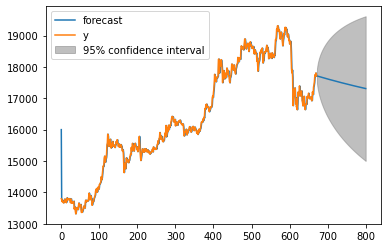

In [37]:
model = ARIMA(data.values, order=(1,0,1))# ARMA
model_fit = model.fit(disp=0)

print(len(data))

fig = model_fit.plot_predict(start=0, end=800)